In [92]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from msc_project.utils.fit_NLS import *

plt.style.use('ggplot')

In [179]:
def plot_polarization_with_fit(ax, pulse_width, partial_pol, polarization_fit, **kwargs):
    ax.scatter(pulse_width, partial_pol, **kwargs)


    voltage = polarization_fit[1]
    r2 = polarization_fit[-1]
    popt = polarization_fit[2:-1]
    n, A, omega, log_tlorentz = popt

    label = f'{voltage:.2f}V:\t$A$={A:.2f}, $\\omega$={omega:.2f},\t$\\log(t_{{Lorentz}})$={log_tlorentz:.2f}\t($R^2$={r2:.3f})'

    t = np.logspace(np.log10(pulse_width.min()), np.log10(pulse_width.max()), 1000)
    p = polarization_lorentzian(t, A, omega, log_tlorentz, n)

    ax.plot(t, p, label=label, **kwargs)

def plot_all_polarizations_with_fit(ax, exp_data, polarization_fits):
    norm = clr.Normalize()
    cmap = plt.cm.plasma
    colors = cmap(norm(exp_data.columns[1:].astype(float)))

    for col, c in zip(exp_data.columns[1:], colors):
        polarization_fit = polarization_fits[polarization_fits['voltage'] == float(col)]
        if len(polarization_fit) == 0:
            print(f"No fit data for {col}V")
            continue
        elif len(polarization_fit) > 1:
            print(f"Multiple fits found for {col}V")
            continue

        plot_polarization_with_fit(ax, exp_data["Pulse Width"], exp_data[col], polarization_fit.values[0], color=c)

def plot_tau_l_with_fit(ax, voltage, log_tlorentz, tau_fit, inverse_v=False, **kwargs):
    ax.scatter(voltage, log_tlorentz, **kwargs)

    popt = tau_fit[2:-1]
    r2 = tau_fit[-1]

    label = f'$\\log(t_{{Lorentz}})$ (fit):\n$t_0$={popt[0]:.2e}s\n$V_0$={popt[1]:.2f}V\n($R^2$={r2:.3f})'

    v = np.linspace(voltage.min(), voltage.max(), 1000)
    t = f_tau(v, *popt)
    if inverse_v:
        v = 1/v

    ax.plot(v, np.log(t), label=label, **kwargs)

def plot_all_with_fit(axs, exp_data, polarization_fits, tau_fits_pos, tau_fits_neg):
    plot_all_polarizations_with_fit(axs[0], exp_data, polarization_fits)

    voltage = polarization_fits[polarization_fits['voltage'] > 0]['voltage']
    if len(voltage) > 0:
        log_tlor = polarization_fits[polarization_fits['voltage'] > 0]['log_tlorentz']
        plot_tau_l_with_fit(axs[1], voltage, log_tlor, tau_fits_pos.values[0])

    voltage = polarization_fits[polarization_fits['voltage'] < 0]['voltage']
    if len(voltage) > 0:
        log_tlor = polarization_fits[polarization_fits['voltage'] < 0]['log_tlorentz']
        plot_tau_l_with_fit(axs[1], voltage, log_tlor, tau_fits_neg.values[0])


def make_polarization_plot(polarization_fits, tau_fits, exp_data, n, size, title=None, savefig=None):
    size_pol_fits = polarization_fits[polarization_fits['size'] == size]
    size_tau_fits = tau_fits[tau_fits['size'] == size]

    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    fig.suptitle(f"Size: {size}nm; n={n}" if title is None else title)

    n_pol_fits = size_pol_fits[np.isclose(size_pol_fits['n'], n, atol=0.01)]
    n_tau_fits_pos = size_tau_fits[np.isclose(size_tau_fits['n'], n, atol=0.01)]

    plot_all_with_fit(axs, exp_data, n_pol_fits, n_tau_fits_pos, None)

    axs[0].set(xlabel='Pulse duration (s)', ylabel='Partial polarization', xscale='log', ylim=(0, 1))
    axs[0].legend(loc='center left', prop={'size': 7})
    axs[1].set(xlabel='Voltage (V)', ylabel='$\\log(t_{{lorentz}})$  ($\\log(s)$)')
    axs[1].legend()

    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

def plot_tau_vs_size(tau_fits, suptitle="", minsize=0, cmap=None, savefig=None, select_n=None):
    tau_df = tau_fits.sort_values(by='size', ignore_index=True)

    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    fig.suptitle(suptitle)

    n_vals = tau_df['n'].unique()
    n_vals = sorted(n_vals)

    n_vals = [n for n in n_vals if np.any(np.isclose(n, select_n, atol=0.01))] if select_n is not None else n_vals

    if cmap is not None:
        colors = cmap(np.linspace(0, 1, len(n_vals)))
        cmap = mcolors.ListedColormap(colors)
        d = (n_vals[-1] - n_vals[0]) / len(n_vals)
        norm = mcolors.BoundaryNorm(boundaries=np.linspace(n_vals[0]-d/2, n_vals[-1]+d/2, len(n_vals)+1), ncolors=cmap.N)
        cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), ax=axs[1], ticks=n_vals)
        cbar.set_label("n")
    else:
        colors = [f"C{i}" for i in range(len(n_vals))]

    for n,c in zip(n_vals, colors):       
        n_df = tau_df[(tau_df['n'] == n) & (tau_df['size'] >= minsize)]
        # plot tau vs. size on the left
        axs[0].plot(n_df['size'], n_df['t0'], label=f"n={n}", marker='o', color=c)
        # plot V0 vs. size on the right
        axs[1].plot(n_df['size'], n_df['V0'], label=f"n={n}", marker='o', color=c)


    axs[0].set(xlabel='Size (nm)', ylabel='$t_0\\ (s)$', yscale='log')
    axs[1].set(xlabel='Size (nm)', ylabel='$V_0\\ (V)$')
    if cmap is None:
        axs[0].legend()
        axs[1].legend()
    plt.tight_layout()

    if savefig is not None:
        plt.savefig(savefig)
    plt.show()


In [182]:
polarization_fits = pd.read_csv('/scratch/msc24h18/msc_project/results/nls_model/20250122_144739/polarization_fits.csv')
tau_fits = pd.read_csv('/scratch/msc24h18/msc_project/results/nls_model/20250122_144739/tau_fits.csv')
exp_data = load_data('/scratch/msc24h18/msc_project/data/Data_for_NLS/10000 nm ID2946.csv', format=0)

FIGURES_DIR = '/scratch/msc24h18/msc_project/results/report_figures/'

No fit data for 5.00V


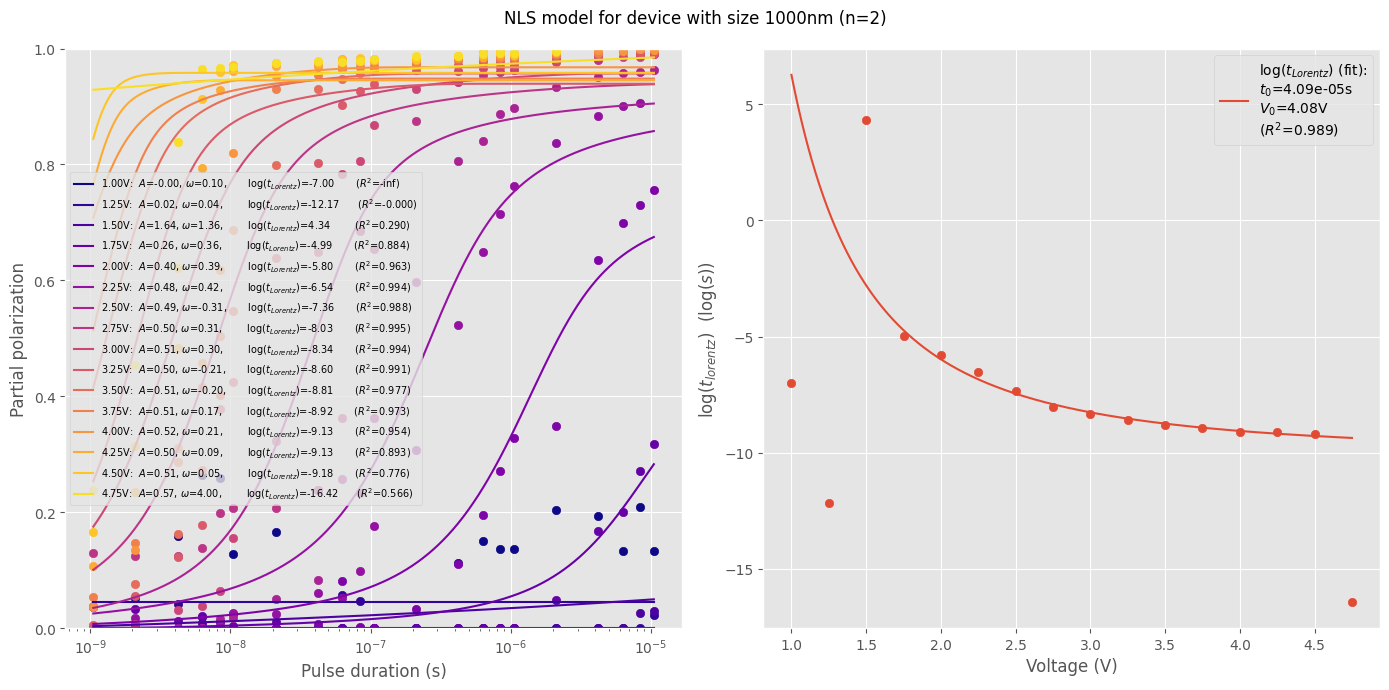

No fit data for 1.50V


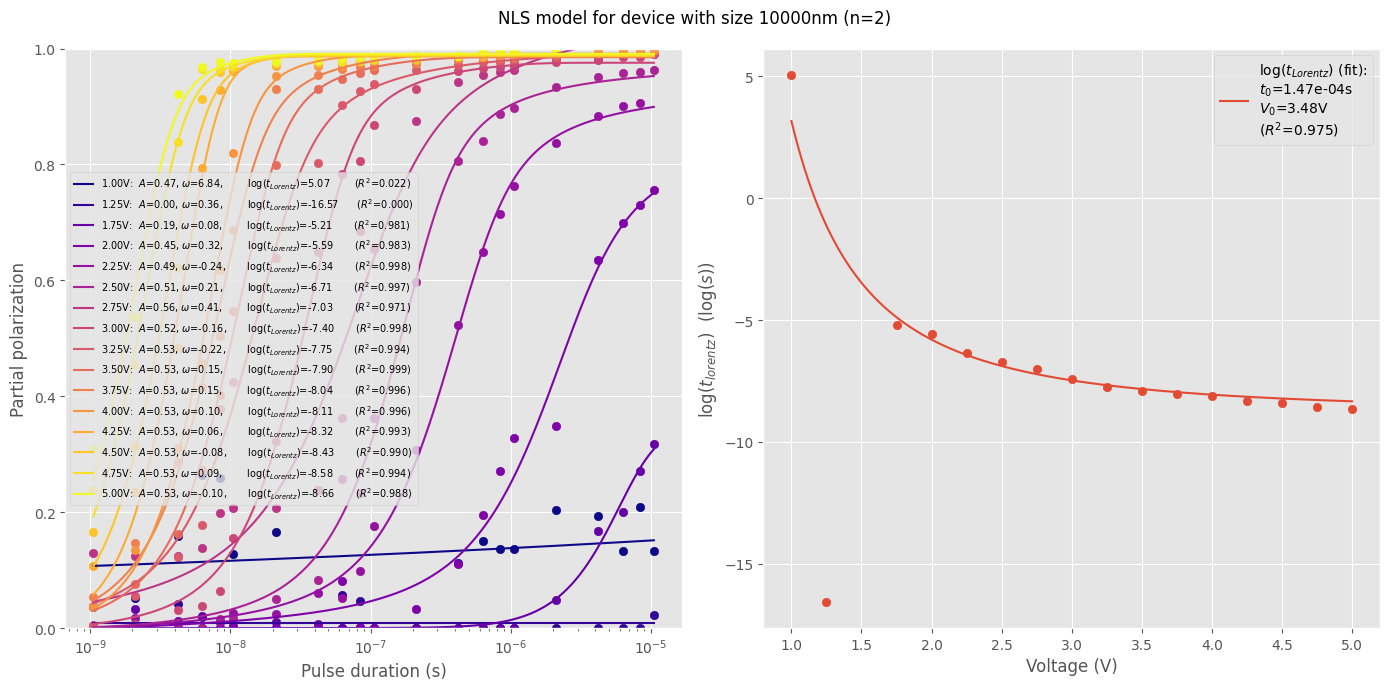

In [189]:
make_polarization_plot(polarization_fits, tau_fits, exp_data, n=2, size=1000,
          title=f"NLS model for device with size 1000nm (n=2)",
          savefig=FIGURES_DIR+'nls_model_1000nm_n2.png')
make_polarization_plot(polarization_fits, tau_fits, exp_data, n=2, size=10000,
          title=f"NLS model for device with size 10000nm (n=2)",
          savefig=FIGURES_DIR+'nls_model_10000nm_n2.png')

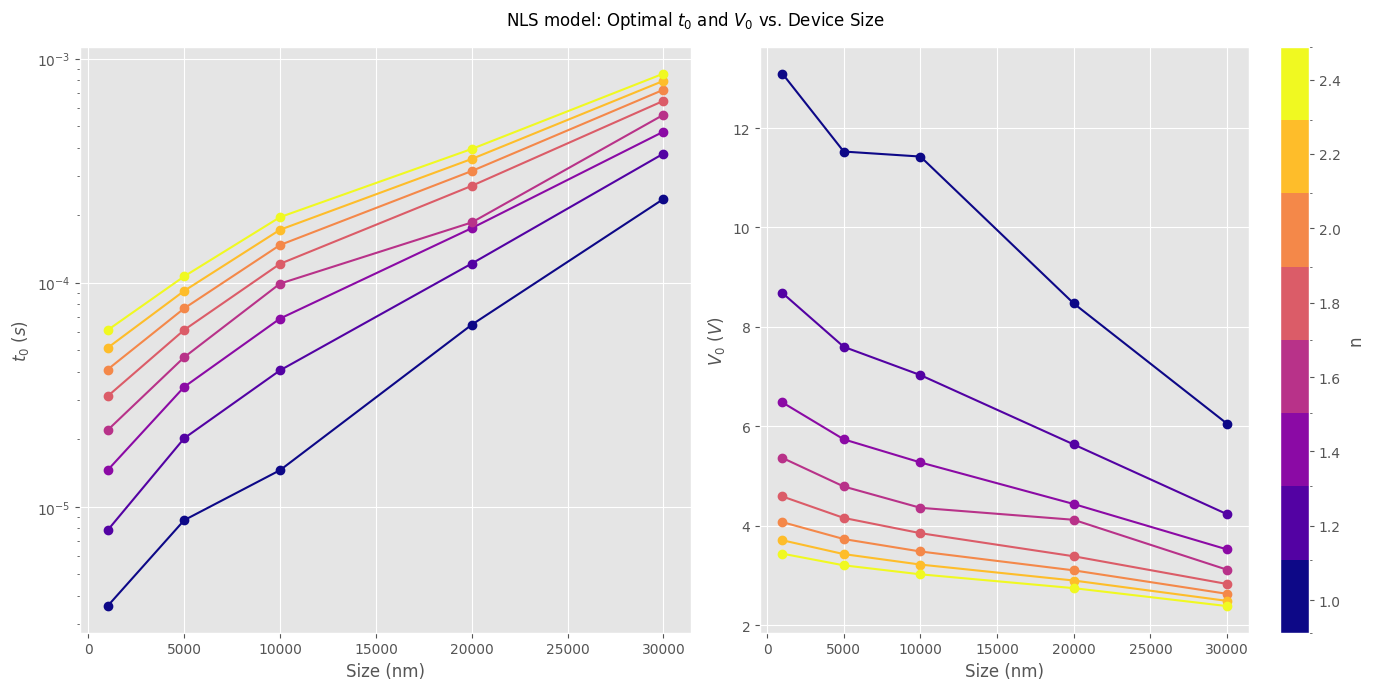

In [188]:
plot_tau_vs_size(tau_fits, suptitle="NLS model: Optimal $t_0$ and $V_0$ vs. Device Size",
                 cmap=plt.cm.plasma, select_n=np.linspace(1, 2.4, 8), minsize=1000,
                 savefig=FIGURES_DIR+'nls_model_tauV0_vs_size.png')